# Multivariate ARIMA Stock Prediction - NASDAQ Comp

Stock Prediction of NASDAQ Comp using multiple features.

**Data source:** Yahoo Finance

**Features:** NASDAQ Comp Close, Daily % Change of 18 NASDAQ Comp components, US Treasury Yield
>`^IXIC_Close`, `^IXIC_%_Daily_Change`, `^DJI_%_Daily_Change`,
               `^GSPC_%_Daily_Change`, `AAPL_%_Daily_Change`, `MSFT_%_Daily_Change`,
               `AMZN_%_Daily_Change`, `FB_%_Daily_Change`, `GOOG_%_Daily_Change`,
               `GOOGL_%_Daily_Change`, `TSLA_%_Daily_Change`, `NVDA_%_Daily_Change`,
               `ASML_%_Daily_Change`, `INTC_%_Daily_Change`, `CMCSA_%_Daily_Change`,
               `NFLX_%_Daily_Change`, `ADBE_%_Daily_Change`, `CSCO_%_Daily_Change`,
               `PEP_%_Daily_Change`, `AVGO_%_Daily_Change`, `TXN_%_Daily_Change`,
               `TMUS_%_Daily_Change`, `^IRX_%_Daily_Change`, `^FVX_%_Daily_Change`,
               `^TNX_%_Daily_Change`, `^TYX_%_Daily_Change`

**Train/Test Ratio:** 0.85 / 0.15

**Reference:** https://www.analyticsvidhya.com/blog/2021/07/stock-market-forecasting-using-time-series-analysis-with-arima-model/

## Load required libraries

In [2]:
# import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

## Load Data

In [3]:
# dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv("Cleaned_Data_Stock_Prediction.csv")
df.Date=pd.to_datetime(df.Date)
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 347 columns):
 #    Column                                          Dtype         
---   ------                                          -----         
 0    Date                                            datetime64[ns]
 1    NASDAQ_Comp_Open                                float64       
 2    NASDAQ_Comp_High                                float64       
 3    NASDAQ_Comp_Low                                 float64       
 4    NASDAQ_Comp_Close                               float64       
 5    NASDAQ_Comp_Adj Close                           float64       
 6    NASDAQ_Comp_Volume                              float64       
 7    NASDAQ_Comp_%_Daily_Return                      float64       
 8    NASDAQ_Comp_Yesterday_Price_Change              float64       
 9    NASDAQ_Comp_%_Daily_Change                      float64       
 10   NASDAQ_Comp_Daily_Change                        float64   

In [16]:
stock_data = pd.concat([df.filter(items=['Date','NASDAQ_Comp_Close']), df.filter(regex=r'%_Daily_Change$', axis=1)], axis=1)
stock_data = stock_data.set_index("Date")
stock_data = stock_data.drop(columns = ['Gold_%_Daily_Change',
       'Oil_%_Daily_Change', 'CNY_USD_%_Daily_Change',
       'GBP_USD_%_Daily_Change', 'JPY_USD_%_Daily_Change',
       'EUR_USD_%_Daily_Change', 'CAD_USD_%_Daily_Change'])
stock_data

,NASDAQ_Comp_Close,NASDAQ_Comp_%_Daily_Change,Dow_Jones_%_Daily_Change,S_P_500_%_Daily_Change,AAPL_%_Daily_Change,MSFT_%_Daily_Change,AMZN_%_Daily_Change,FB_%_Daily_Change,GOOG_%_Daily_Change,GOOGL_%_Daily_Change,...,ADBE_%_Daily_Change,CSCO_%_Daily_Change,PEP_%_Daily_Change,AVGO_%_Daily_Change,TXN_%_Daily_Change,TMUS_%_Daily_Change,_13_Week_Treasury_Bill_%_Daily_Change,Treasury_Yield_5_Years_%_Daily_Change,Treasury_Yield_10_Years_%_Daily_Change,Treasury_Yield_30_Years_%_Daily_Change
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-01,2747.479980,-0.022248,0.001844,0.002458,-0.013458,-0.004868,-0.004989,-0.058498,-0.002746,-0.002746,...,-0.016134,-0.006219,0.006565,-0.037311,-0.037736,0.008143,0.181818,0.020602,-0.013807,-0.013082
2012-06-04,2760.010010,0.000633,0.022419,0.024705,-0.000410,-0.003844,0.031099,-0.018382,0.009172,0.009172,...,0.010375,0.005006,-0.001334,-0.020500,0.000370,-0.017771,0.153846,0.069876,0.031333,0.012476
2012-06-05,2778.110107,0.017051,0.001551,0.000368,0.011581,0.012978,0.003647,-0.023596,0.001790,0.001790,...,0.023849,0.014321,-0.000742,0.039895,0.025148,0.019737,0.066667,-0.008708,0.027796,0.023874
2012-06-06,2844.719971,0.027115,-0.001973,-0.006059,0.016767,0.026316,0.023389,0.035673,0.019290,0.019289,...,0.037205,0.036218,0.007130,0.051258,0.042208,0.016129,0.000000,0.076135,0.053459,0.036856
2012-06-07,2831.020020,-0.016793,-0.023479,-0.023204,-0.009856,-0.014507,-0.004735,-0.016667,-0.019997,-0.019997,...,-0.025265,-0.018957,-0.000738,-0.017948,-0.028383,-0.015873,-0.062500,-0.092517,-0.065075,-0.034095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-24,14369.709960,0.003033,0.000431,-0.001809,-0.007363,0.000263,-0.012441,0.002165,-0.000760,-0.005705,...,0.004758,-0.003211,0.006213,0.003107,0.000000,0.002820,0.131579,0.018973,0.002022,-0.005241
2021-06-25,14360.389650,0.001180,-0.011483,-0.004089,-0.000375,-0.000150,-0.013857,-0.000379,0.000339,0.005562,...,0.007034,0.007391,0.006861,-0.011350,0.004892,-0.003567,0.000000,-0.004381,0.014795,0.022510
2021-06-28,14500.509770,0.006338,-0.002905,-0.002439,0.010419,0.010068,0.006680,0.040326,-0.001791,-0.000065,...,0.006985,-0.005079,0.004702,0.013670,0.013494,-0.003993,0.046512,0.001100,-0.011266,-0.013115


In [17]:
stock_data.columns

Index(['NASDAQ_Comp_Close', 'NASDAQ_Comp_%_Daily_Change',
       'Dow_Jones_%_Daily_Change', 'S_P_500_%_Daily_Change',
       'AAPL_%_Daily_Change', 'MSFT_%_Daily_Change', 'AMZN_%_Daily_Change',
       'FB_%_Daily_Change', 'GOOG_%_Daily_Change', 'GOOGL_%_Daily_Change',
       'TSLA_%_Daily_Change', 'NVDA_%_Daily_Change', 'ASML_%_Daily_Change',
       'INTC_%_Daily_Change', 'CMCSA_%_Daily_Change', 'NFLX_%_Daily_Change',
       'ADBE_%_Daily_Change', 'CSCO_%_Daily_Change', 'PEP_%_Daily_Change',
       'AVGO_%_Daily_Change', 'TXN_%_Daily_Change', 'TMUS_%_Daily_Change',
       '_13_Week_Treasury_Bill_%_Daily_Change',
       'Treasury_Yield_5_Years_%_Daily_Change',
       'Treasury_Yield_10_Years_%_Daily_Change',
       'Treasury_Yield_30_Years_%_Daily_Change'],
      dtype='object')

## Visualize Closing Price

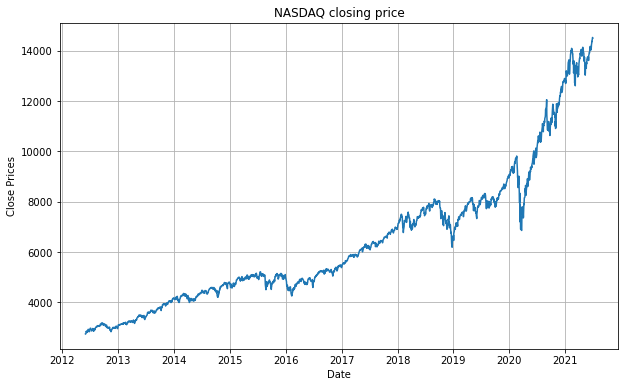

In [8]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['NASDAQ_Comp_Close'])
plt.title('NASDAQ closing price')
plt.show()

## ADF (Augmented Dickey-Fuller) Test

In [9]:
df_close = stock_data['NASDAQ_Comp_Close']

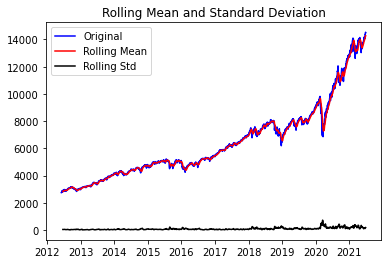

Results of dickey fuller test
Test Statistics                   2.322354
p-value                           0.998969
No. of lags used                 26.000000
Number of observations used    2240.000000
critical value (1%)              -3.433273
critical value (5%)              -2.862831
critical value (10%)             -2.567457
dtype: float64


In [10]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 432x288 with 0 Axes>

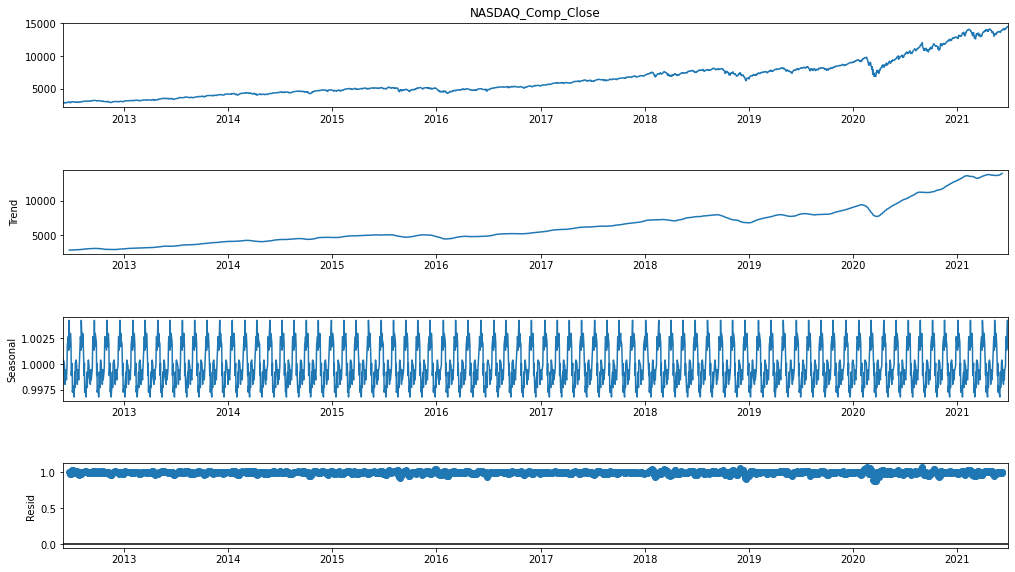

In [11]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

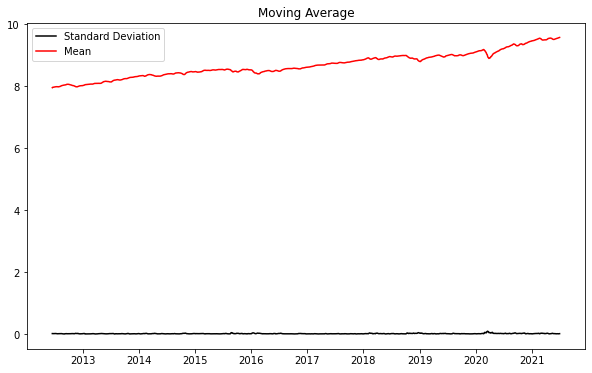

In [12]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
# plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

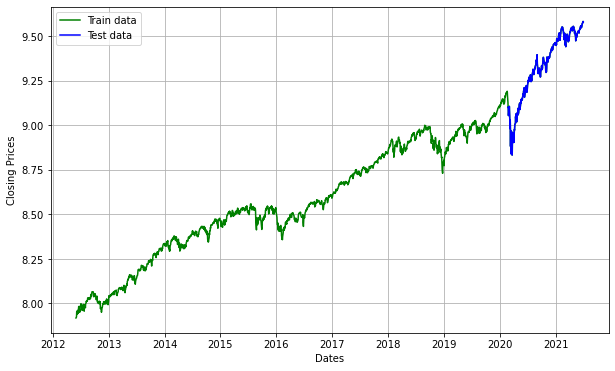

In [13]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.85)], df_log[int(len(df_log)*0.85):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

## Run Autoarima with exogenous variables

In [14]:
df2 = stock_data.loc["2012-06-06":"2020-02-24"]
df2

,NASDAQ_Comp_Close,NASDAQ_Comp_%_Daily_Change,Dow_Jones_%_Daily_Change,S_P_500_%_Daily_Change,AAPL_%_Daily_Change,MSFT_%_Daily_Change,AMZN_%_Daily_Change,FB_%_Daily_Change,GOOG_%_Daily_Change,GOOGL_%_Daily_Change,...,Treasury_Yield_5_Years_%_Daily_Change,Treasury_Yield_10_Years_%_Daily_Change,Treasury_Yield_30_Years_%_Daily_Change,Gold_%_Daily_Change,Oil_%_Daily_Change,CNY_USD_%_Daily_Change,GBP_USD_%_Daily_Change,JPY_USD_%_Daily_Change,EUR_USD_%_Daily_Change,CAD_USD_%_Daily_Change
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-06,2844.719971,0.027115,-0.001973,-0.006059,0.016767,0.026316,0.023389,0.035673,0.019290,0.019289,...,0.076135,0.053459,0.036856,0.000093,0.000238,-0.000550,-0.006308,0.006872,-0.008986,-0.008016
2012-06-07,2831.020020,-0.016793,-0.023479,-0.023204,-0.009856,-0.014507,-0.004735,-0.016667,-0.019997,-0.019997,...,-0.092517,-0.065075,-0.034095,-0.002281,-0.016140,0.000754,-0.002632,0.005399,0.000528,-0.001157
2012-06-08,2858.419922,0.020777,-0.003554,0.000882,0.028202,0.017802,-0.005123,0.023729,0.014518,0.014518,...,0.080960,0.043423,0.028539,0.018011,0.022360,0.000801,-0.000931,-0.001744,-0.006046,-0.005452
2012-06-11,2809.729980,-0.023122,-0.007408,-0.008094,-0.022562,-0.021191,0.000736,0.011038,-0.024717,-0.024717,...,-0.029126,-0.014688,-0.001825,-0.005399,-0.024382,-0.000173,0.003263,-0.003117,0.013404,0.009005
2012-06-12,2843.070068,0.007912,0.011420,0.012464,0.000104,0.004124,-0.009786,0.006550,-0.014129,-0.014128,...,0.082857,0.043478,0.021214,0.005776,0.055925,-0.000345,-0.005111,0.002761,-0.002121,-0.004172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-18,9732.740234,0.010721,0.005385,0.002683,0.014713,0.013200,0.020132,0.020791,0.006647,0.008492,...,0.016691,0.012306,0.009543,-0.001578,-0.013785,0.002421,0.000429,0.000901,0.003923,0.001179
2020-02-19,9817.179688,0.001675,-0.001021,-0.003358,0.008219,-0.005902,0.002431,-0.006743,-0.002013,-0.005363,...,-0.013562,-0.016635,-0.013930,-0.010804,0.002111,0.000143,0.005538,0.011589,-0.001382,-0.002301
2020-02-20,9750.969727,-0.009306,0.000562,-0.000018,-0.012429,-0.020219,-0.014229,-0.014040,-0.009179,-0.009500,...,-0.028944,-0.033832,-0.031786,-0.006595,-0.025794,0.003601,0.003633,0.006879,0.002032,0.002866


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17164.911, Time=6.59 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17165.490, Time=9.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-17165.571, Time=10.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17153.414, Time=12.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-17163.974, Time=10.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-17164.661, Time=11.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-17148.647, Time=52.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-17166.163, Time=18.52 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-17164.573, Time=7.49 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-17165.175, Time=14.80 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-17166.079, Time=11.46 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-17168.283, Time=17.26 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-17157.050, Time=6.77 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-17165.772, Time=20.50

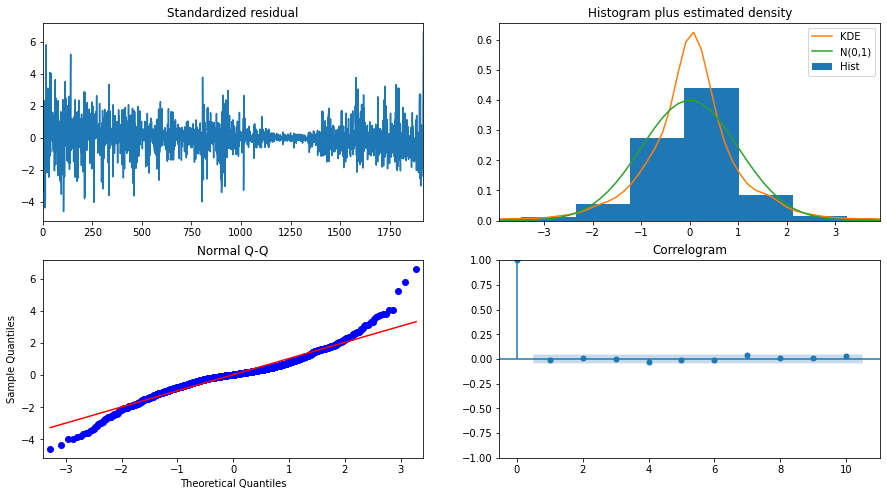

In [18]:
df3 = df2[['NASDAQ_Comp_Close', 'NASDAQ_Comp_%_Daily_Change',
       'Dow_Jones_%_Daily_Change', 'S_P_500_%_Daily_Change',
       'AAPL_%_Daily_Change', 'MSFT_%_Daily_Change', 'AMZN_%_Daily_Change',
       'FB_%_Daily_Change', 'GOOG_%_Daily_Change', 'GOOGL_%_Daily_Change',
       'TSLA_%_Daily_Change', 'NVDA_%_Daily_Change', 'ASML_%_Daily_Change',
       'INTC_%_Daily_Change', 'CMCSA_%_Daily_Change', 'NFLX_%_Daily_Change',
       'ADBE_%_Daily_Change', 'CSCO_%_Daily_Change', 'PEP_%_Daily_Change',
       'AVGO_%_Daily_Change', 'TXN_%_Daily_Change', 'TMUS_%_Daily_Change',
       '_13_Week_Treasury_Bill_%_Daily_Change',
       'Treasury_Yield_5_Years_%_Daily_Change',
       'Treasury_Yield_10_Years_%_Daily_Change',
       'Treasury_Yield_30_Years_%_Daily_Change']]
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      exogenous= df3)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [19]:
#Modeling
# Build Model

model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                              ARIMA Model Results                              
Dep. Variable:     D.NASDAQ_Comp_Close   No. Observations:                 1922
Model:                  ARIMA(0, 1, 0)   Log Likelihood                6167.029
Method:                            css   S.D. of innovations              0.010
Date:                 Mon, 21 Feb 2022   AIC                         -12330.057
Time:                         03:01:42   BIC                         -12318.935
Sample:                              1   HQIC                        -12325.965
                                                                               
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      2.743      0.006       0.000       0.001


/Users/carolho/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/carolho/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [20]:
# Forecast
fc, se, conf = fitted.forecast(341, alpha=0.05)  # 95% conf

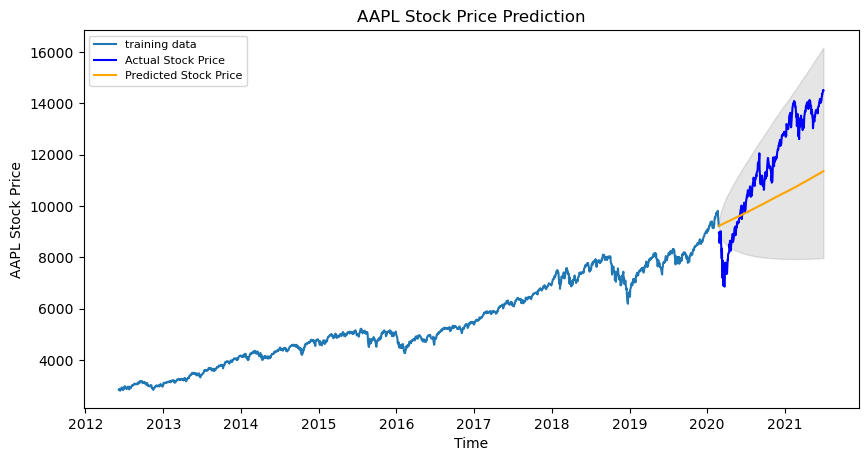

In [21]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = np.exp(pd.Series(conf[:, 0], index=test_data.index))
upper_series = np.exp(pd.Series(conf[:, 1], index=test_data.index))
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data), label='training data')
plt.plot(np.exp(test_data), color = 'blue', label='Actual Stock Price')
plt.plot(np.exp(fc_series), color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Get the predicted values
# y_pred = fc_series

# Unscale the predicted values
y_pred = np.exp(fc_series)
y_test = np.exp(test_data)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test, y_pred)/ y_test))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test, y_pred)/ y_test)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Mean Absolute Error (MAE): 1672.11
Mean Absolute Percentage Error (MAPE): 13.98 %
Median Absolute Percentage Error (MDAPE): 14.93 %
